In [1]:
from basicsr import build_model
import misalignSR
from basicsr.utils.registry import DATASET_REGISTRY, MODEL_REGISTRY, ARCH_REGISTRY 
from basicsr.utils.options import yaml_load

/home/kanghyun/mambaforge/envs/misalignsr/lib/python3.9/site-packages/torchvision/transforms/functional_tensor.py:5: UserWarning: The torchvision.transforms.functional_tensor module is deprecated in 0.15 and will be **removed in 0.17**. Please don't rely on it. You probably just need to use APIs in torchvision.transforms.functional or in torchvision.transforms.v2.functional.
  warnings.warn(


## Root path 설정해주기

In [2]:
import pyrootutils
from pathlib import Path
import os

cwd = Path().resolve()
root = pyrootutils.setup_root(
    search_from=cwd,
    indicator=".project-root",
    project_root_env_var=True,
    dotenv=True,
    pythonpath=True,
    cwd=True,
) # root: root folder path of the directory

print("Path for the root folder is:")
print(root)

Path for the root folder is:
/home/kanghyun/MisalignSR


## 데이터셋 Configuration

In [3]:
from icecream import ic # printing function

# dataset option
data_opt = {}

data_opt["dataroot_gt"] = os.path.join(root, "datasets/DIV2K/DIV2K_train_HR_sub")
data_opt["dataroot_lq"] = os.path.join(root, "datasets/DIV2K/DIV2K_train_LR_bicubic/X3_sub")
data_opt["gt_size"] = 96
data_opt["scale"] = 3
data_opt["phase"] = "train"

data_opt["use_hflip"] = True # Train 시에만 적용
data_opt["use_rot"] = True

data_opt["io_backend"] = {}
data_opt["io_backend"]["type"] = "disk"

_ = ic(data_opt)

ic| data_opt: {'dataroot_gt': '/home/kanghyun/MisalignSR/datasets/DIV2K/DIV2K_train_HR_sub',
               'dataroot_lq': '/home/kanghyun/MisalignSR/datasets/DIV2K/DIV2K_train_LR_bicubic/X3_sub',
               'gt_size': 96,
               'io_backend': {'type': 'disk'},
               'phase': 'train',
               'scale': 3,
               'use_hflip': True,
               'use_rot': True}


## 데이터셋 만들기

In [4]:
dataset = DATASET_REGISTRY.get('PairedImageDataset')(data_opt)

## 데이터셋 output 살펴보기

In [5]:
ind = 10

train_batch = dataset[ind]
# lq: low quality, gt: ground truth, lq_path: low quality path, gt_path: ground truth path

_ = ic(train_batch.keys())
_ = ic(train_batch["lq"].shape)
_ = ic(train_batch["gt"].shape)
_ = ic(train_batch["lq_path"])
_ = ic(train_batch["gt_path"])

ic| train_batch.keys(): dict_keys(['lq', 'gt', 'lq_path', 'gt_path'])
ic| train_batch["lq"].shape: torch.Size([3, 32, 32])
ic| train_batch["gt"].shape: torch.Size([3, 96, 96])
ic| train_batch["lq_path"]: '/home/kanghyun/MisalignSR/datasets/DIV2K/DIV2K_train_LR_bicubic/X3_sub/0350_s010.png'
ic| train_batch["gt_path"]: '/home/kanghyun/MisalignSR/datasets/DIV2K/DIV2K_train_HR_sub/0350_s010.png'


## Dataloader 구성하기

In [12]:
data_loader_opt = {}
data_loader_opt["batch_size_per_gpu"] = 16
data_loader_opt["num_worker_per_gpu"] = 4
data_loader_opt["phase"] = 'train'


In [78]:
from basicsr import build_dataloader
train_loader = build_dataloader(dataset, data_loader_opt, num_gpu=1)

## network 구성하기

In [8]:
network_g = ARCH_REGISTRY.get('RCAN')(num_in_ch=3, num_out_ch=3, upscale=3)

In [9]:
# Testing in CPU mode
estY = network_g(train_batch["lq"])
ic(train_batch["lq"].shape)
ic(estY.shape)
ic(train_batch["gt"].shape)

ic| train_batch["lq"].shape: torch.Size([3, 32, 32])
ic| estY.shape: torch.Size([1, 3, 96, 96])
ic| train_batch["gt"].shape: torch.Size([3, 96, 96])


torch.Size([3, 96, 96])

## Model 구성하기 
[Introduction Link](https://github.com/XPixelGroup/BasicSR/blob/master/docs/introduction.md) 참고

Model은 training / validation / testing 을 관장하는 코드 (i.e., setup, feed_data, training step, validation)


In [79]:
# options for the model

opt = {}
# General settings
opt["path"] = {}
opt["is_train"] = True
opt["num_gpu"] = 1
opt["dist"] = False

# Network architecture
opt["network_g"] = {"type": "RCAN", "num_in_ch": 3, "num_out_ch": 3, "upscale": 3}

# Training settings
opt["train"] = {
    "ema_decay": 0.999, # EMA decay rate
    "optim_g": {"type": "Adam", "lr": 0.0001, "weight_decay": 0, "betas": [0.9, 0.99]}, # optimizer
    "scheduler": {"type": "MultiStepLR", "milestones": [200000], "gamma": 0.5}, # learning rate scheduler
    "total_iter": 300000,
    "warmup_iter": -1,
    "pixel_opt": {'type':'L1Loss','loss_weight':1.0, 'reduction':'mean'} # L1 loss
}

opt['logger'] = {
    'print_freq': 100, # print log every 100 iterations
    'save_checkpoint_freq': 10000, # save checkpoint every 10000 iterations
    'use_tb_logger': False, # use tensorboard logger
}


In [80]:
training_model = MODEL_REGISTRY.get('SRModel')(opt)

In [40]:
epoch = 1

training_model.feed_data(train_batch)
training_model.optimize_parameters(epoch)

out = training_model.get_current_visuals()

ic(out.keys())

/home/kanghyun/BasicSR/basicsr/losses/basic_loss.py:14: UserWarning: Using a target size (torch.Size([3, 96, 96])) that is different to the input size (torch.Size([1, 3, 96, 96])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.l1_loss(pred, target, reduction='none')
ic| out.keys(): odict_keys(['lq', 'result', 'gt'])


odict_keys(['lq', 'result', 'gt'])

## Intermediate visualization

In [46]:
from basicsr import tensor2img
import matplotlib.pyplot as plt

In [49]:
result = tensor2img(out['result'])
lq = tensor2img(out['lq'])
gt = tensor2img(out['gt'])

fig, axes = plt.subplots(1, 3, figsize=(20, 10))
axes[0].imshow(lq)
axes[1].imshow(result)
axes[2].imshow(gt)



## Final end to end

Iter:1000, loss:0.018029743805527687


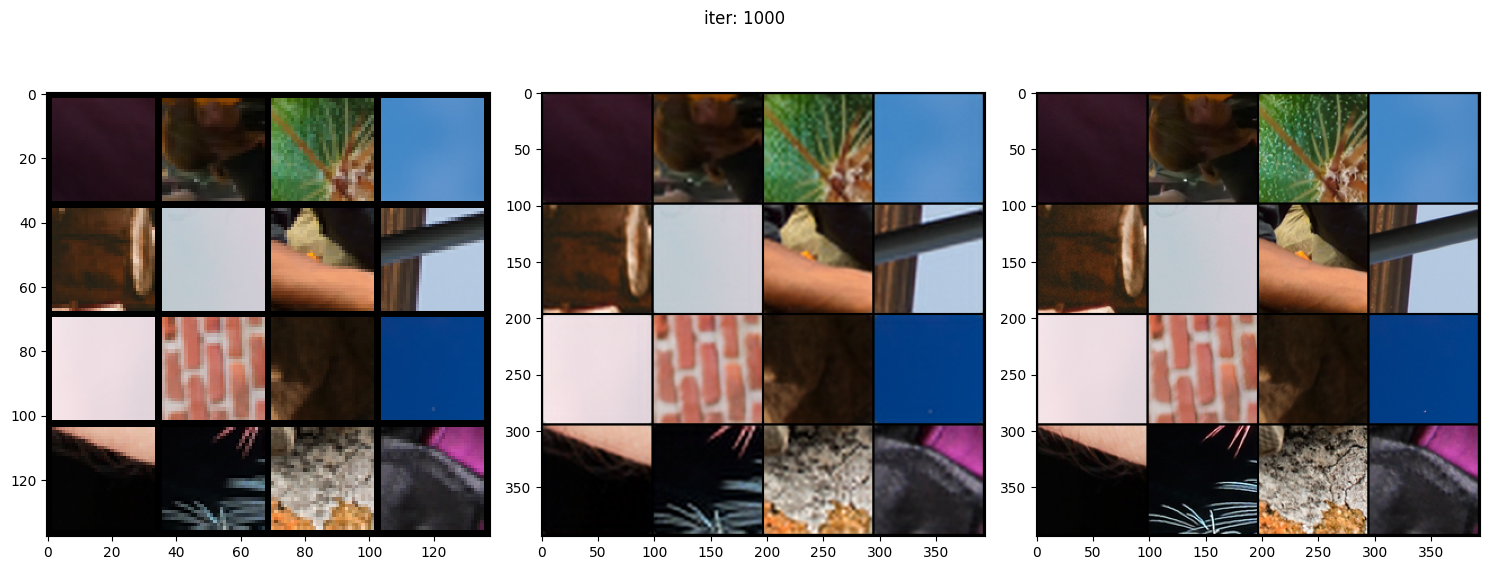

Iter:2000, loss:0.031099114567041397


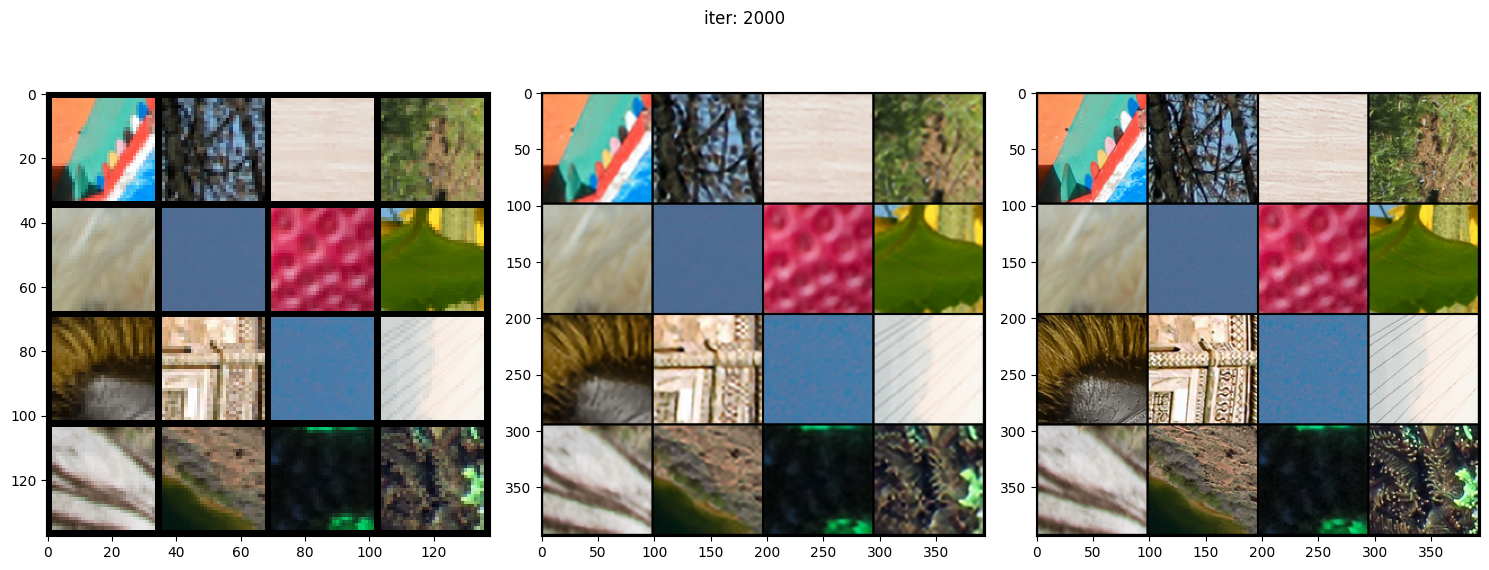

In [81]:
iter = 0
for epoch in range(10):
    for train_batch in train_loader:
        training_model.feed_data(train_batch)
        training_model.optimize_parameters(iter)
        iter += 1
        if iter % 1000 == 0:
            print('Iter:{}, loss:{}'.format(iter, training_model.get_current_log()['l_pix'])) # current log
            out = training_model.get_current_visuals()
            result = tensor2img(out['result'], rgb2bgr=False)
            lq = tensor2img(out['lq'], rgb2bgr=False)
            gt = tensor2img(out['gt'], rgb2bgr=False)

            fig, axes = plt.subplots(1, 3, figsize=(15, 6))
            axes[0].imshow(lq)
            axes[1].imshow(result)
            axes[2].imshow(gt)
            fig.suptitle(f"iter: {iter}", fontsize=12)
            fig.tight_layout()
            plt.show()
            plt.close(fig)